In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import random
import networkx as nx
from node2vec import Node2Vec
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Loading data
nodes_df = pd.read_csv("nodes_cleaned.csv")
edges_df = pd.read_csv("edges_cleaned.csv")

# Handling duplicates
if nodes_df['spotify_id'].duplicated().any():
    nodes_df = nodes_df.drop_duplicates(subset=['spotify_id']).reset_index(drop=True)

# Creating node index mapping
node_index_map = {spotify_id: idx for idx, spotify_id in enumerate(nodes_df['spotify_id'])}
edges_df['Source'] = edges_df['id_0'].map(node_index_map)
edges_df['Target'] = edges_df['id_1'].map(node_index_map)

# Creating edge index
edge_index = torch.tensor(edges_df[['Source', 'Target']].to_numpy().T, dtype=torch.long)

# Spliting edges into train/test
train_pos_edges, test_pos_edges = train_test_split(edge_index.T, test_size=0.2, random_state=42)



In [2]:
# Generating Node2Vec embeddings from training subgraph

train_graph = nx.Graph()
train_graph.add_edges_from(train_pos_edges.cpu().numpy().tolist())

In [3]:


# Training Node2Vec model
node2vec = Node2Vec(train_graph, 
                   dimensions=32,
                   walk_length=10,
                   num_walks=50,
                   workers=4)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Creating embedding matrix for all nodes
embedding_dim = 32
node_embeddings = np.zeros((len(nodes_df), embedding_dim))
for node in range(len(nodes_df)):
    try:
        # Convert node index to string for Node2Vec lookup
        node_embeddings[node] = model.wv[str(node)]
    except KeyError:
        # Handle nodes not present in the training subgraph
        node_embeddings[node] = np.zeros(embedding_dim)
# Combining with original features
# ==============================
genre_columns = [
    'alternative Indie', 'classical_orchestral', 'electronic', 'folk world',
    'jazz', 'hip_hop', 'latin', 'metal', 'pop', 'randb_Soul',
    'reggae_dancehall', 'rock', 'soundtrack', 'unknown'
]

original_features = nodes_df[['popularity', 'followers'] + genre_columns].to_numpy()
combined_features = np.concatenate([original_features, node_embeddings], axis=1)

node_features = torch.tensor(combined_features, dtype=torch.float)



Computing transition probabilities:   0%|          | 0/116114 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [12:36<00:00, 63.02s/it]


In [4]:
node_embeddings=np.load("node_embeddings..npy")
# Combining with original features
# ==============================
genre_columns = [
    'alternative Indie', 'classical_orchestral', 'electronic', 'folk world',
    'jazz', 'hip_hop', 'latin', 'metal', 'pop', 'randb_Soul',
    'reggae_dancehall', 'rock', 'soundtrack', 'unknown'
]

original_features = nodes_df[['popularity', 'followers'] + genre_columns].to_numpy()
combined_features = np.concatenate([original_features, node_embeddings], axis=1)

node_features = torch.tensor(combined_features, dtype=torch.float)


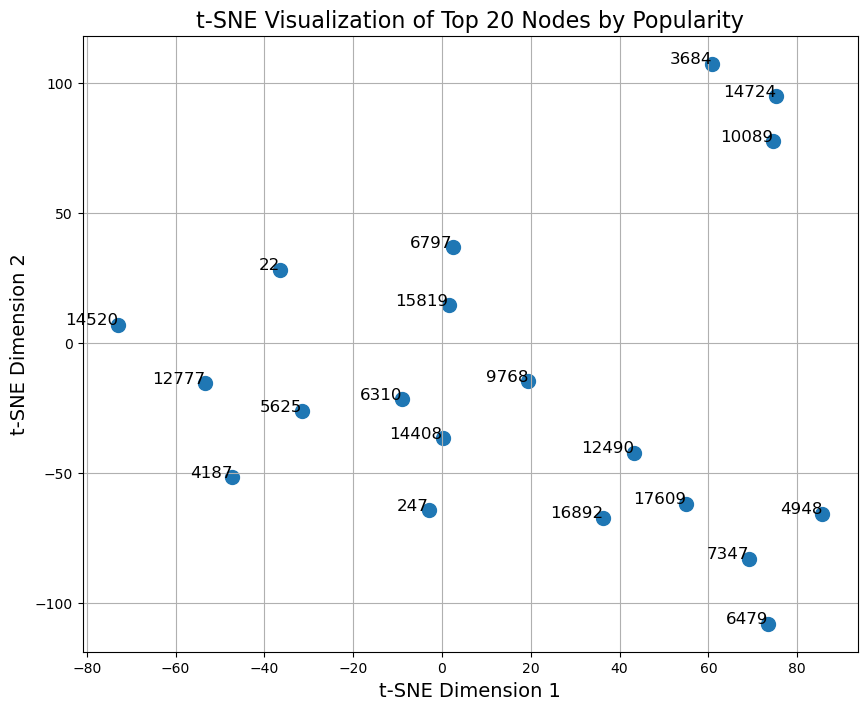

In [5]:

# Select top 20 nodes based on popularity
top_20_indices = nodes_df['popularity'].nlargest(20).index  # Indices of top 20 popular nodes
top_20_embeddings = node_embeddings[top_20_indices]  # Embeddings for top 20 nodes

#Applying t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  
embeddings_2d = tsne.fit_transform(top_20_embeddings)

# Plotting the 2D embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100) 

#annotating points with node indices or labels
for i, (x, y) in enumerate(embeddings_2d):
    plt.text(x, y, str(top_20_indices[i]), fontsize=12, ha='right')

plt.title("t-SNE Visualization of Top 20 Nodes by Popularity", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.grid(True)
plt.show()

In [6]:
# Generating negative edges and create datasets

def generate_negative_edges(num_nodes, existing_edges, num_samples):
    existing_edges_set = set(map(tuple, existing_edges.T.tolist()))
    negative_edges = set()
    while len(negative_edges) < num_samples:
        i, j = np.random.randint(0, num_nodes, size=2)
        if i != j and (i, j) not in existing_edges_set and (j, i) not in existing_edges_set:
            negative_edges.add((i, j))
    return torch.tensor(list(negative_edges), dtype=torch.long)

num_train_neg = len(train_pos_edges)
num_test_neg = len(test_pos_edges)
train_neg_edges = generate_negative_edges(len(nodes_df), train_pos_edges, num_train_neg)
test_neg_edges = generate_negative_edges(len(nodes_df), test_pos_edges, num_test_neg)

# Creating final datasets
train_edges = torch.cat([train_pos_edges, train_neg_edges], dim=0)
test_edges = torch.cat([test_pos_edges, test_neg_edges], dim=0)
train_labels = torch.cat([torch.ones(len(train_pos_edges)), torch.zeros(len(train_neg_edges))])
test_labels = torch.cat([torch.ones(len(test_pos_edges)), torch.zeros(len(test_neg_edges))])

# Creating graph data object with COMBINED FEATURES
train_data = Data(x=node_features, edge_index=train_pos_edges.T)



In [7]:
# Model 

class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.edge_predictor = torch.nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x

    def predict_edges(self, x, edges):
        edge_embeds = torch.cat([x[edges[:, 0]], x[edges[:, 1]]], dim=1)
        return torch.sigmoid(self.edge_predictor(edge_embeds)).squeeze()

# Training setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(input_dim=combined_features.shape[1], hidden_dim=64).to(device)
train_data = train_data.to(device)
train_edges, train_labels = train_edges.to(device), train_labels.to(device)
test_edges, test_labels = test_edges.to(device), test_labels.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-4)



In [8]:
# Training loop

def train():
    model.train()
    optimizer.zero_grad()
    embeddings = model(train_data.x, train_data.edge_index)
    pred = model.predict_edges(embeddings, train_edges)
    loss = F.binary_cross_entropy(pred, train_labels.float())
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        embeddings = model(train_data.x, train_data.edge_index)
        pred = model.predict_edges(embeddings, test_edges)
        pred_labels = (pred > 0.5).float()
        accuracy = (pred_labels == test_labels.float()).sum() / len(test_labels)
   
        test_loss = F.binary_cross_entropy(pred, test_labels.float())

        # Return accuracy, true labels, predicted labels, and validation loss
        return accuracy.item(), test_labels.cpu().numpy(), pred_labels.cpu().numpy(), test_loss.item()




In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Initialize lists to store loss and accuracy values
train_loss_values = []
test_loss_values = []
accuracy_values = []

# Variables to track best metrics
best_accuracy = 0
best_loss = float('inf')
best_cm = None
best_epoch = 0
best_report = ""

for epoch in range(1, 201):
    # Training phase
    train_loss = train()  
    train_loss_values.append(train_loss)  

    # Validation phase
    acc, y_true, y_pred, test_loss = test()  
    test_loss_values.append(test_loss)  
    accuracy_values.append(acc)

    # Check for best accuracy and lowest loss
    if acc > best_accuracy or test_loss < best_loss:
        best_accuracy = acc
        best_loss = test_loss
        best_cm = confusion_matrix(y_true, y_pred)
        best_epoch = epoch
        best_report = classification_report(y_true, y_pred, target_names=["No Collaboration", "Collaboration"])

    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Test Accuracy: {acc:.4f}')

# Extract best confusion matrix values
tn, fp, fn, tp = best_cm.ravel()

# Print best results
print(f"\nBest Results at Epoch {best_epoch}:")
print(f"Highest Accuracy: {best_accuracy:.4f}")
print(f"Lowest Loss: {best_loss:.4f}")

print("\nConfusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nInterpretation:")
print("TN: Predicted no collaboration correctly (actual no collaboration)")
print("FP: Predicted collaboration incorrectly (actual no collaboration)")
print("FN: Predicted no collaboration incorrectly (actual collaboration)")
print("TP: Predicted collaboration correctly (actual collaboration)")

print(f'\nClassification Report:\n{best_report}')


Epoch 010, Train Loss: 0.1681, Val Loss: 0.5124, Test Accuracy: 0.8043
Epoch 020, Train Loss: 0.1659, Val Loss: 0.5324, Test Accuracy: 0.7994
Epoch 030, Train Loss: 0.1641, Val Loss: 0.5545, Test Accuracy: 0.7938
Epoch 040, Train Loss: 0.1626, Val Loss: 0.5796, Test Accuracy: 0.7874
Epoch 050, Train Loss: 0.1612, Val Loss: 0.5931, Test Accuracy: 0.7847
Epoch 060, Train Loss: 0.1600, Val Loss: 0.6168, Test Accuracy: 0.7795
Epoch 070, Train Loss: 0.1588, Val Loss: 0.6298, Test Accuracy: 0.7770
Epoch 080, Train Loss: 0.1578, Val Loss: 0.6473, Test Accuracy: 0.7740
Epoch 090, Train Loss: 0.1569, Val Loss: 0.6600, Test Accuracy: 0.7721
Epoch 100, Train Loss: 0.1562, Val Loss: 0.6848, Test Accuracy: 0.7687
Epoch 110, Train Loss: 0.1554, Val Loss: 0.6923, Test Accuracy: 0.7677
Epoch 120, Train Loss: 0.1546, Val Loss: 0.7005, Test Accuracy: 0.7667
Epoch 130, Train Loss: 0.1540, Val Loss: 0.7125, Test Accuracy: 0.7654
Epoch 140, Train Loss: 0.1534, Val Loss: 0.7236, Test Accuracy: 0.7643
Epoch 

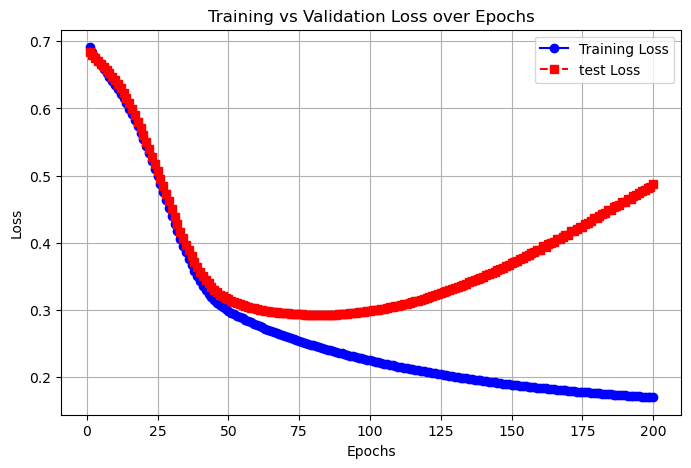

In [10]:
# Plot the loss function graph (Training vs Validation)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 201), train_loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
plt.plot(range(1, 201), test_loss_values, marker='s', linestyle='--', color='r', label="test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [11]:


# Converting existing edges to a set for fast lookup
existing_edges_set = set(map(tuple, edge_index.T.tolist()))  # Set of existing edges for quick lookup

# Number of unseen pairs to sample
num_samples = 100
unseen_pairs = []

# Randomly sampling node pairs and check if they're not connected
while len(unseen_pairs) < num_samples:
    i, j = random.sample(range(len(nodes_df)), 2)  # Randomly sample two nodes
    
    # Ensuring the pair is not already an existing edge
    if i != j and (i, j) not in existing_edges_set and (j, i) not in existing_edges_set:
        unseen_pairs.append((i, j))

# Converting to tensor
unseen_pairs = torch.tensor(unseen_pairs, dtype=torch.long).to(device)


In [12]:

model.eval()

# Predicting collaboration probabilities for unseen pairs
with torch.no_grad():
    # Getting node embeddings from the trained GraphSAGE model
    embeddings = model(train_data.x, train_data.edge_index)
    
    # Predicting probabilities for unseen pairs
    pred_probs = model.predict_edges(embeddings, unseen_pairs)

# Converting predictions to a numpy array for easier handling
pred_probs = pred_probs.cpu().numpy()

# Combining unseen pairs with their predicted probabilities
unseen_pairs_with_probs = list(zip(unseen_pairs.cpu().numpy(), pred_probs))

# Sorting the pairs by predicted probability (descending order)
unseen_pairs_with_probs.sort(key=lambda x: x[1], reverse=True)

# Displaying the top 10 most likely collaborations
print("Top 10 Predicted New Collaborations:")

artist_names = nodes_df['name'].tolist()

for pair, prob in unseen_pairs_with_probs[:10]:
    artist1, artist2 = pair
    print(f"{artist_names[artist1]} and {artist_names[artist2]}: Collaboration Probability = {prob:.4f}")

Top 10 Predicted New Collaborations:
Afrojack and David Shawty: Collaboration Probability = 0.9968
Samantha Cole and Kygo: Collaboration Probability = 0.7722
Sai Sen and DIMMA: Collaboration Probability = 0.3189
Layter and Cornstick: Collaboration Probability = 0.2934
Tag Shai and Jackson Guthy: Collaboration Probability = 0.2526
Young Kenna and Franco Zarate: Collaboration Probability = 0.2509
Albert Gold and Mario: Collaboration Probability = 0.2079
Molera and El Blopa: Collaboration Probability = 0.2011
DJ Isaac and John Neal: Collaboration Probability = 0.1826
Celimpilo and The Madd: Collaboration Probability = 0.1658


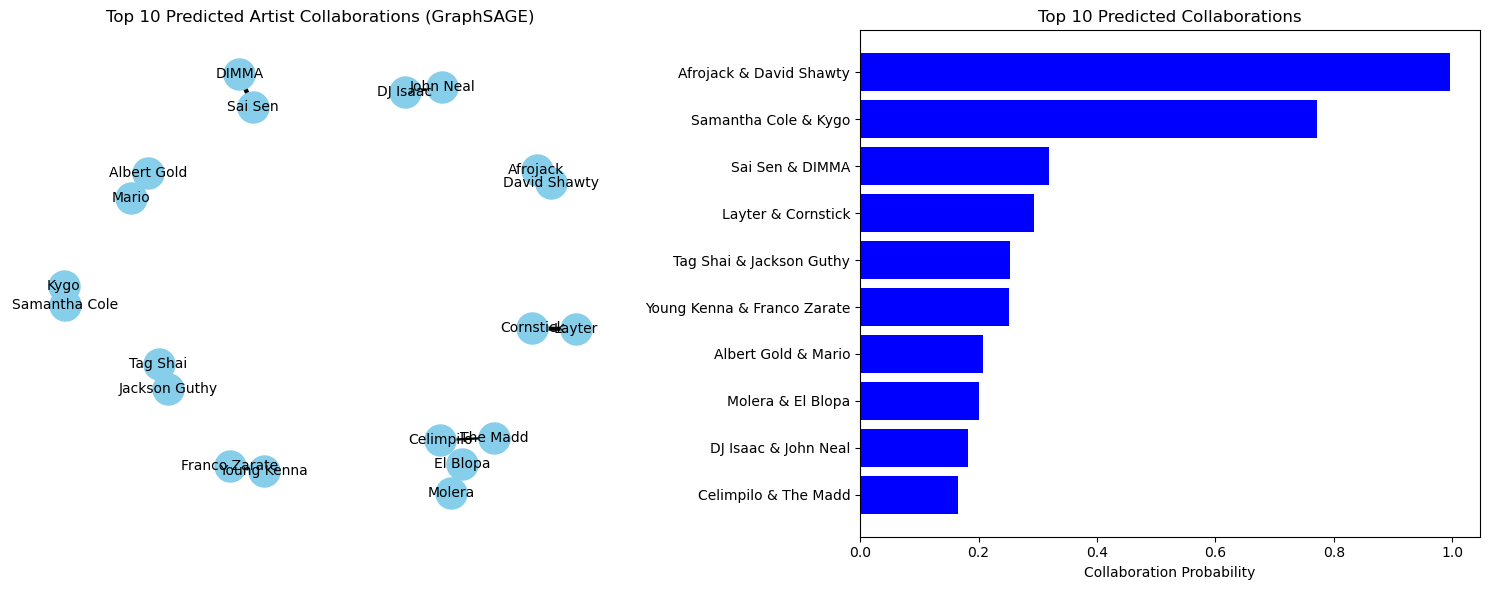

In [19]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create a graph
G = nx.Graph()

# Extract top 10 predicted collaborations
top_collaborations = unseen_pairs_with_probs[:10]

# Lists to store artist pair names and probabilities for bar plot
collab_names = []
collab_probs = []

for (artist1, artist2), prob in top_collaborations:
    artist_pair = f"{artist_names[artist1]} & {artist_names[artist2]}"
    collab_names.append(artist_pair)
    collab_probs.append(prob)
    
    # Add edge to graph
    G.add_edge(artist_names[artist1], artist_names[artist2], weight=prob)

# Set node positions
pos = nx.spring_layout(G, seed=42)

# Extract edge weights
edges = G.edges(data=True)
weights = [d['weight'] * 10 for (_, _, d) in edges]  # Scale for visualization

# Create figure with two subplots (Graph & Bar Chart)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- 1st Plot: Network Graph ---
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="black",
        width=weights, node_size=500, font_size=10, ax=axes[0])

axes[0].set_title("Top 10 Predicted Artist Collaborations (GraphSAGE)")

# --- 2nd Plot: Bar Chart ---
axes[1].barh(collab_names[::-1], collab_probs[::-1], color='blue')  # Reverse for better visualization
axes[1].set_xlabel("Collaboration Probability")
axes[1].set_title("Top 10 Predicted Collaborations")

# Display plots
plt.tight_layout()
plt.show()
